# Regression Uncertainty Robustness
## Plotting loss functions

- toc: false
- branch: master
- badges: true
- comments: true
- image: images/nig_regression.png
- categories: [probability, regression, uncertainty, robustness]

## Robustness

Robustness

### Robustness during training vs testing

In [1]:
#hide
import numpy as np
import pandas as pd

import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as Data

import matplotlib.pyplot as plt
from matplotlib import ticker, cm

%matplotlib inline

import imageio
torch.manual_seed(1)    # reproducible

In [0]:
#hide
# this is one way to define a network
class Net(torch.nn.Module):
    def __init__(self, n_feature, n_hidden, n_output):
        super(Net, self).__init__()
        self.hidden = torch.nn.Linear(n_feature, n_hidden)   # hidden layer
        self.predict = torch.nn.Linear(n_hidden, n_output)   # output layer

    def forward(self, x):
        x = F.relu(self.hidden(x))      # activation function for hidden layer
        x = self.predict(x)             # linear output
        return x


In [0]:
#hide
#data generation
#Construct some regression data with some extreme outliers.
np.random.seed(1)
n = 50
scale_true = 0.7
shift_true = 0.15
x = np.random.uniform(size=n)
#x = np.linspace(0, 1, 50)
y = scale_true * x + shift_true
y += np.random.normal(scale=0.025, size=n)
flip_mask = np.random.uniform(size=n) > 0.9
y = np.where(flip_mask, 0.05 + 0.4 * (1. - np.sign(y - 0.5)), y)

x = torch.Tensor(x)
y = torch.Tensor(y)
x = torch.unsqueeze(x, dim=1)
y = torch.unsqueeze(y, dim=1)

Text(0, 0.5, '$y$')

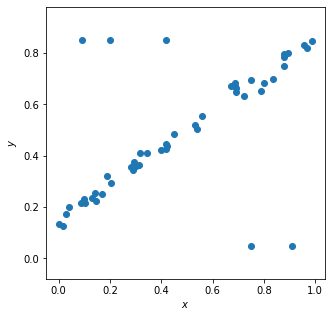

In [26]:
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(x.data.numpy(),y.data.numpy())
ax.axis('equal')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')

## Mean Square Loss robustness analysis

In [0]:
loss_func = torch.nn.MSELoss()  # this is for regression mean squared loss
# Fit a linear regression using mean squared error.
regression = Net(n_feature=1, n_hidden=1, n_output=1)     # RegressionModel() 
params = regression.parameters()
optimizer = torch.optim.Adam(params, lr = 0.001) 

tensor(0.7375, grad_fn=<MseLossBackward>)
tensor(0.4496, grad_fn=<MseLossBackward>)
tensor(0.2274, grad_fn=<MseLossBackward>)
tensor(0.1069, grad_fn=<MseLossBackward>)
tensor(0.0638, grad_fn=<MseLossBackward>)
tensor(0.0530, grad_fn=<MseLossBackward>)
tensor(0.0495, grad_fn=<MseLossBackward>)
tensor(0.0472, grad_fn=<MseLossBackward>)
tensor(0.0451, grad_fn=<MseLossBackward>)
tensor(0.0433, grad_fn=<MseLossBackward>)
tensor(0.0417, grad_fn=<MseLossBackward>)
tensor(0.0403, grad_fn=<MseLossBackward>)
tensor(0.0391, grad_fn=<MseLossBackward>)
tensor(0.0381, grad_fn=<MseLossBackward>)
tensor(0.0372, grad_fn=<MseLossBackward>)
tensor(0.0365, grad_fn=<MseLossBackward>)
tensor(0.0359, grad_fn=<MseLossBackward>)
tensor(0.0354, grad_fn=<MseLossBackward>)
tensor(0.0350, grad_fn=<MseLossBackward>)
tensor(0.0346, grad_fn=<MseLossBackward>)


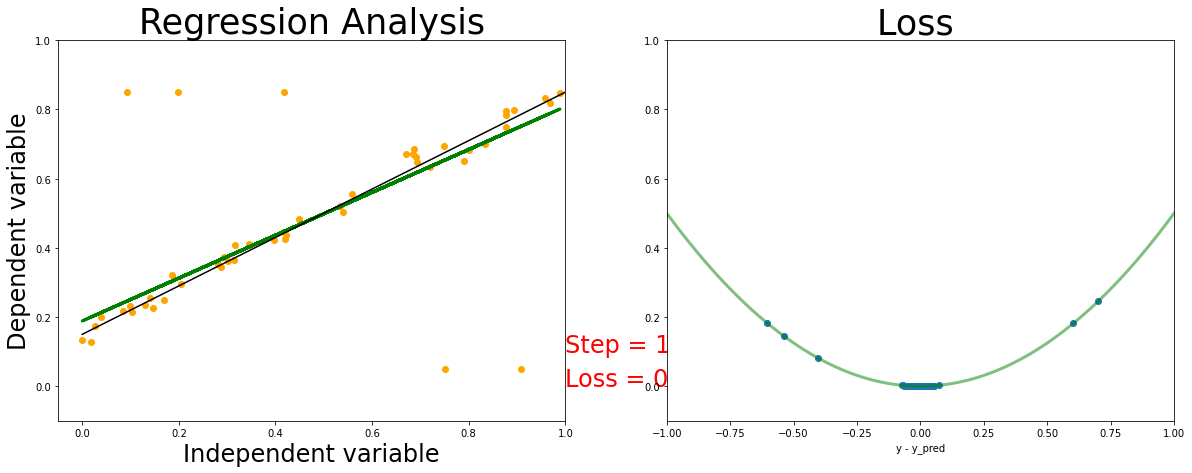

In [44]:
#hide

def l2_loss(y, y_):
  return 0.5*(y - y_)**2

my_images = []
fig, (ax1, ax2) = plt.subplots(figsize=(20,7), nrows=1, ncols=2)

# train the network
for epoch in range(2000):
  
    prediction = regression(x)     # input x and predict based on x

    loss = loss_func(prediction, y)     # must be (1. nn output, 2. target)
    #if t%10 == 0: print (loss)

    optimizer.zero_grad()   # clear gradients for next train
    loss.backward()         # backpropagation, compute gradients
    optimizer.step()        # apply gradients
    if np.mod(epoch, 100) == 0:
      print (loss)

      # plot and show learning process
      plt.cla()
      ax1.cla()
      ax1.set_title('Regression Analysis', fontsize=35)
      ax1.set_xlabel('Independent variable', fontsize=24)
      ax1.set_ylabel('Dependent variable', fontsize=24)
      ax1.set_xlim(-0.05, 1.0)
      ax1.set_ylim(-0.1, 1.0)
      ax1.scatter(x.data.numpy(), y.data.numpy(), color = "orange")
      ax1.plot(x.data.numpy(), prediction.data.numpy(), 'g-', lw=3)
      l2_loss_plot_x = np.linspace(0,1,num=100)
      y_plot_true = l2_loss_plot_x * scale_true + shift_true
      ax1.plot(l2_loss_plot_x, y_plot_true, 'k')
      ax1.text(1.0, 0.1, 'Step = %d' % epoch, fontdict={'size': 24, 'color':  'red'})
      ax1.text(1.0, 0, 'Loss = %.4f' % loss.data.numpy(),
              fontdict={'size': 24, 'color':  'red'})
      diff = prediction.data.numpy() - y.data.numpy()

      ax2.cla()
      l2_loss_plot_x = np.linspace(-1,1,num=100)
      ax2.plot(l2_loss_plot_x, 0.5*l2_loss_plot_x**2, color="green", lw=3, alpha=0.5)
      ax2.scatter(diff, l2_loss(y, prediction).data.numpy())
      ax2.set_title('Loss ', fontsize=35)
      ax2.set_xlabel('y - y_pred')
      ax2.set_ylim(-0.1, 1)
      ax2.set_xlim(-1, 1)
      # Used to return the plot as an image array 
      # (https://ndres.me/post/matplotlib-animated-gifs-easily/)
      fig.canvas.draw()       # draw the canvas, cache the renderer
      image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
      image  = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))

      my_images.append(image)

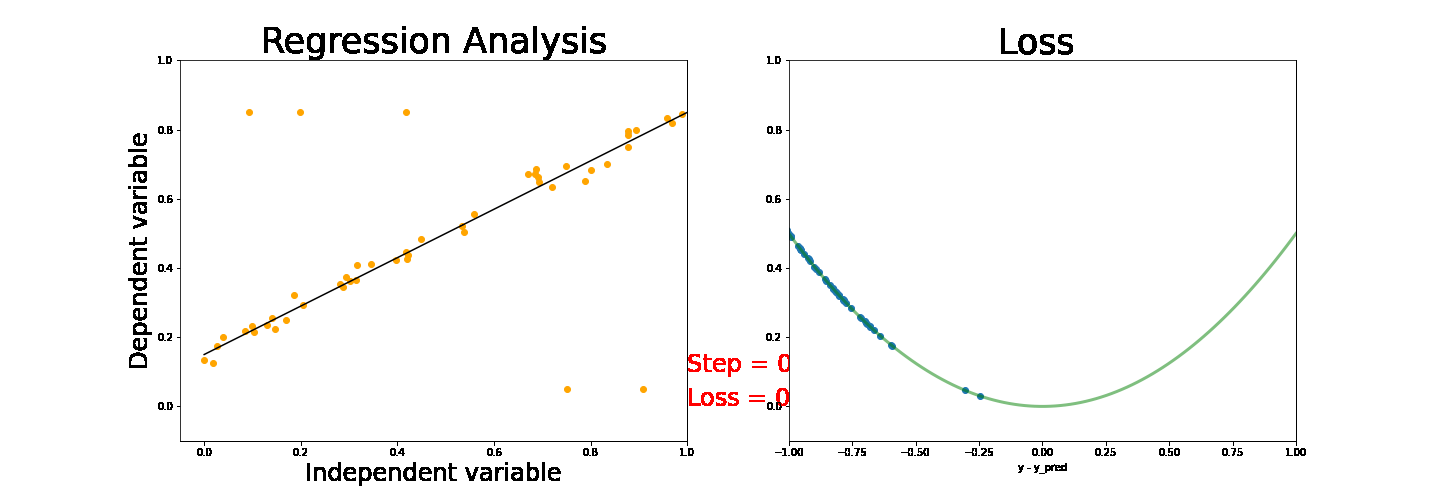

In [46]:
#hide
imageio.mimsave('./mse_reg.gif', my_images, fps=5)
from IPython.display import Image, display

with open('mse_reg.gif','rb') as f:
  display(Image(data=f.read(), format='png'))

### Analysis

![](https://github.com/deebuls/devblog/blob/master/_notebooks/images/mse_reg.gif?raw=true)

## Uncertainty Loss Robustness

### Smaller comparable network


![](https://github.com/deebuls/devblog/blob/master/_notebooks/images/gauss_loss_5.gif?raw=true)

The learning is general

## Larger network 100 nodes
![](https://github.com/deebuls/devblog/blob/master/_notebooks/images/gauss_loss_100.gif?raw=true)

## Plotting Loss Surface

In [47]:
sigma_2 = np.logspace(0.1, 1, num=70, base=10 ) 
print (sigma_2.max(), sigma_2.min())
diff = np.linspace(-3, 5, num=70)
def gauss_logL(xbar, sigma_2, mu):
  return -0.5*np.log(2*np.pi)-0.5*np.log(sigma_2)-0.5*(xbar -mu)**2/sigma_2
xbar = 1
logL = gauss_logL(xbar, sigma_2[:, np.newaxis], diff)
logL -= logL.max()

x_grid, sigma_grid = np.meshgrid(diff, sigma_2)
logL = gauss_logL(xbar, sigma_grid, x_grid)
logL = logL*-1

10.0 1.2589254117941673


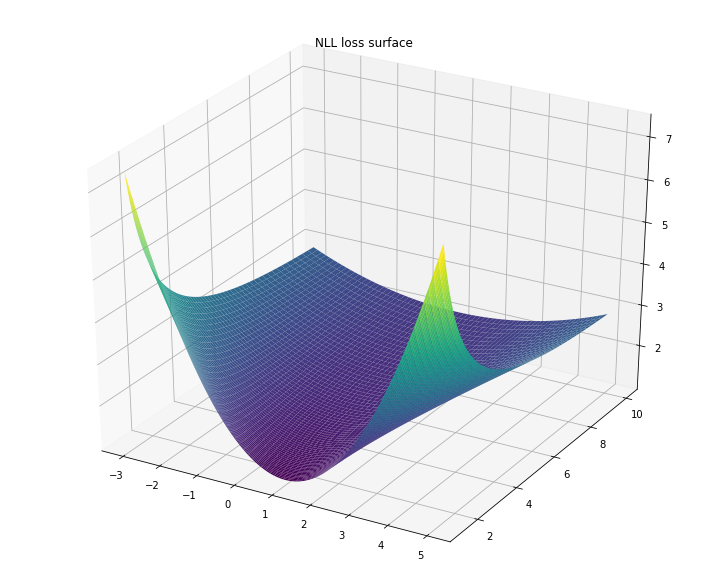

In [49]:
fig, ax = plt.subplots(figsize=(10,8),constrained_layout=True)

ax = plt.axes(projection='3d')
ax.plot_surface(x_grid, sigma_grid, logL, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_title('NLL loss surface');

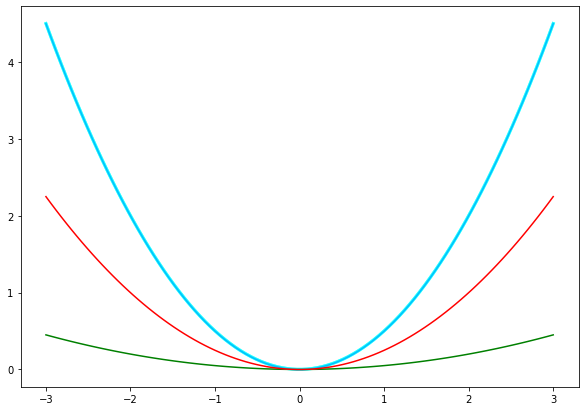

In [54]:
from itertools import cycle
cycol = cycle('bgrcmk')

fig, ax = plt.subplots(figsize=(10,7))

#for s_2 in [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 2]:
for s_2 in [1e-3, 1e-2, 2e-3]:

  x = np.linspace(-3, 3, num=100)
  logL = (-1*gauss_logL(0, s_2, x))/1000
  ax.plot(x, 0.5*x**2, color="cyan", lw=3, alpha=0.5)
  ax.plot(x,logL, c=next(cycol))